In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

In [3]:
df_train = pd.read_csv("D:/1Fall2023_CS_PhD/TA_CS_5101_6101/House_Prices/train.csv")
df_test = pd.read_csv("D:/1Fall2023_CS_PhD/TA_CS_5101_6101/House_Prices/test.csv")

In [4]:
df_train.shape

(1460, 81)

In [5]:
df_test.shape

(1459, 80)

In [6]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### 1. Check the dependant variable : saleprice

In [7]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
df_train['SalePrice'].isna().sum()

0

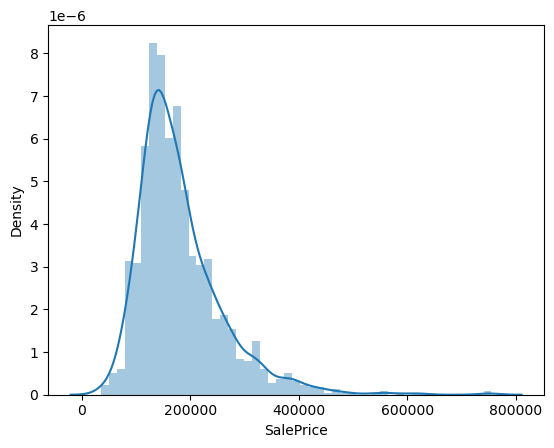

In [9]:
sns.distplot(df_train['SalePrice']);
#sns.boxplot(df_train['SalePrice']);

As it is skewed, will try applying log transformation if it improves model accuracy i.e. goal

#### 2. Check for numerical features which are very similar to each other : multi-collinearity

In [10]:
#split dataset into numerical and categorical features
df_train_num = df_train.select_dtypes(exclude=["object"])
df_train_cat = df_train.select_dtypes(include=["object"])
df_test_num = df_test.select_dtypes(exclude=["object"])
df_test_cat = df_test.select_dtypes(include=["object"])

In [11]:
df_train_num.shape,df_train_cat.shape

((1460, 38), (1460, 43))

In [12]:
correlation_matrix = df_train_num.corr()

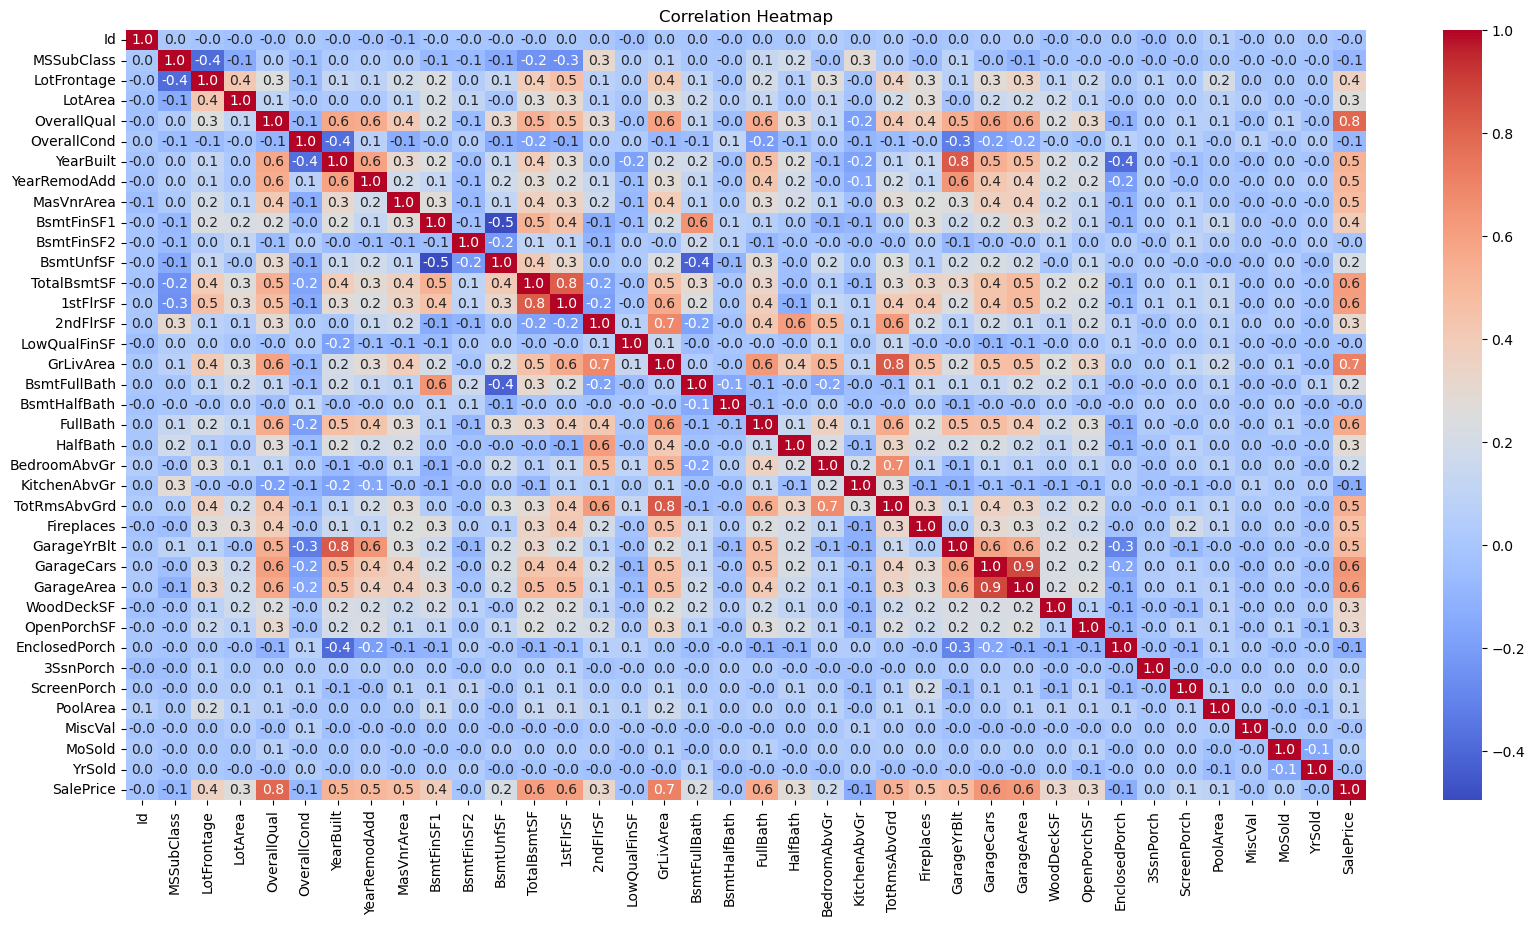

In [13]:
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Heatmap')
plt.show()

##### GrLivArea and TotRmsAbvGrd , YearBuilt and GarageYrBlt, TotalBsmtSF and 1stFlrSF, GarageCars and GarageArea have high correlation with each other - We drop one of those features having the smaller correlation coeffiecient to Target.

In [14]:
df_train1_num = df_train_num.drop(columns=['TotRmsAbvGrd','GarageYrBlt','TotalBsmtSF','GarageArea'])
df_test1_num = df_test_num.drop(columns=['TotRmsAbvGrd','GarageYrBlt','TotalBsmtSF','GarageArea'])

In [15]:
df_train1_num.shape,df_test1_num.shape

((1460, 34), (1459, 33))

#### 3. Check for numerical features which have the same value throughout the dataset : quasi constant features

In [16]:
sel = VarianceThreshold(threshold=0.05) # 0.05: drop column where 95% of the values are constant

# fit finds the features with constant variance
sel.fit(df_train1_num.iloc[:, :-1])

# Get the number of features that are not constant
print(f"Number of retained features: {sum(sel.get_support())}")

print(f"\nNumber of quasi_constant features: {len(df_train1_num.iloc[:, :-1].columns) - sum(sel.get_support())}")

quasi_constant_features_list = [x for x in df_train1_num.iloc[:, :-1].columns if x not in df_train1_num.iloc[:, :-1].columns[sel.get_support()]]

print(f"\nQuasi-constant features to be dropped: {quasi_constant_features_list}")

# Let's drop these columns from df_train_num
df_train1_num.drop(quasi_constant_features_list, axis=1, inplace=True)
df_test1_num.drop(quasi_constant_features_list, axis=1, inplace=True)

Number of retained features: 32

Number of quasi_constant features: 1

Quasi-constant features to be dropped: ['KitchenAbvGr']


In [17]:
df_train1_num.shape,df_test1_num.shape

((1460, 33), (1459, 32))

#### 4. Check for categorical features which are very similar to each other: using chi-square test

#### Visualize the variation of categorical features with respect to the dependant variable

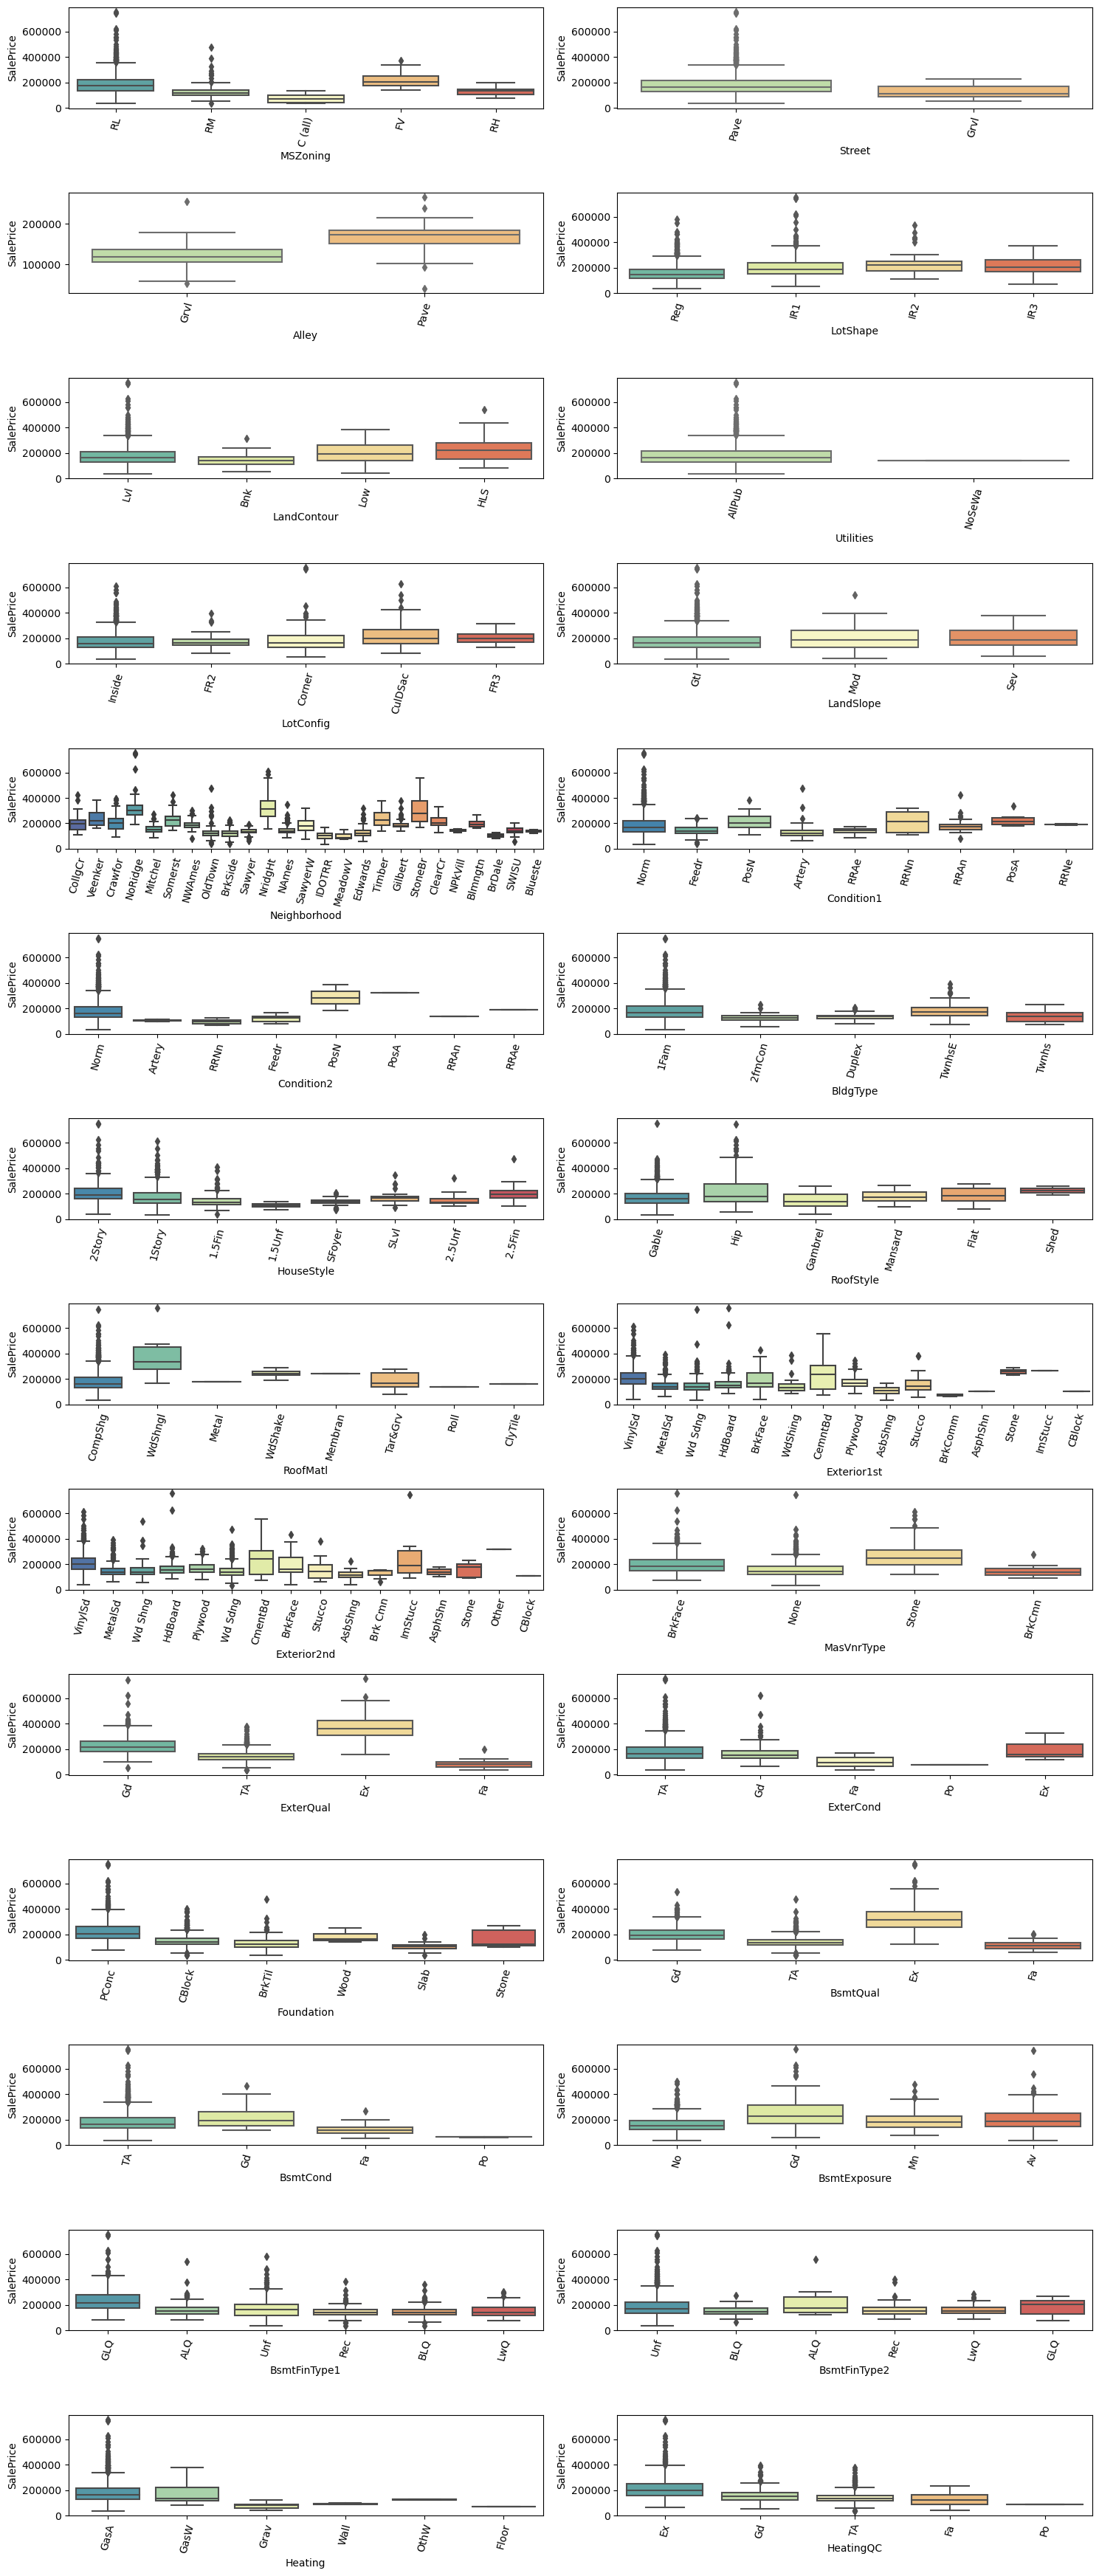

In [18]:
fig, axes = plt.subplots(
    round(len(df_train_cat.columns)/3), 2, figsize=(15, 35))

for i, ax in enumerate(fig.axes):
    # plot the variation of SalePrice in each feature
    if i < len(df_train_cat.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=75)
        sns.boxplot(x=df_train_cat.columns[i], y=df_train1_num["SalePrice"], data=df_train_cat, ax=ax, palette="Spectral_r")

fig.tight_layout()

##### There are pairs of categorical variables for which the distribution of sale price is very similar: "LotShape" and "LandContour", "Exterior1st" and "Exterior2nd", "ExterQual" and "MasVnrType", "BsmtQual" and "BsmtExposure". 

##### If the p-value is very low (<0.05), this indicates that there is evidence to reject the null hypothesis, that the observed distribution is significantly different from the expected distribution. Therefore, we can drop each one of these co-dependant variables

In [19]:
contingency_table = pd.crosstab(df_train_cat['LotShape'], df_train_cat['LandContour'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"P-value: {p}")

P-value: 2.564369065956291e-13


In [20]:
contingency_table = pd.crosstab(df_train_cat['Exterior1st'], df_train_cat['Exterior2nd'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"P-value: {p}")

P-value: 0.0


In [21]:
contingency_table = pd.crosstab(df_train_cat['ExterQual'], df_train_cat['MasVnrType'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"P-value: {p}")

P-value: 1.0187554679218715e-54


In [22]:
contingency_table = pd.crosstab(df_train_cat['BsmtQual'], df_train_cat['BsmtExposure'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"P-value: {p}")

P-value: 3.879215036512606e-32


In [23]:
df_train1_cat = df_train_cat.drop(columns=['LandContour','Exterior2nd','MasVnrType','BsmtExposure'])
df_test1_cat = df_test_cat.drop(columns=['LandContour','Exterior2nd','MasVnrType','BsmtExposure'])

In [24]:
df_train1_cat.shape,df_test1_cat.shape

((1460, 39), (1459, 39))

#### 5. Check for Missing data

In [25]:
df_train1 = pd.concat([df_train1_num, df_train1_cat], axis=1)
df_test1 = pd.concat([df_test1_num, df_test1_cat], axis=1)

In [26]:
df_train1.shape,df_test1.shape

((1460, 72), (1459, 71))

In [27]:
#IDs for train data
df_train1.Id.min(),df_train1.Id.max()

(1, 1460)

In [28]:
#IDs for test data
df_test1.Id.min(),df_test1.Id.max()

(1461, 2919)

In [29]:
df_train1.drop(columns='SalePrice',inplace=True)

In [30]:
df_train1.shape

(1460, 71)

In [31]:
combined_df1 = pd.concat([df_train1, df_test1], axis=0, ignore_index=True)
combined_df1.shape

(2919, 71)

In [32]:
total = combined_df1.isnull().sum().sort_values(ascending=False)
percent = (combined_df1.isnull().sum()/combined_df1.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['#Missing Data', '%Missing Data'])
missing_data.head(20)

,#Missing Data,%Missing Data
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageType,157,0.053786


#### Dropping 6 columns which have more than 15% missing data here

In [33]:
combined_df2 = combined_df1.drop(columns=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage'])

In [34]:
combined_df2.shape

(2919, 65)

#### Imputing Missing Data in both train and test data

In [35]:
#split dataset into numerical and categorical features
combined_df2_num = combined_df2.select_dtypes(exclude=["object"])
combined_df2_cat = combined_df2.select_dtypes(include=["object"])

In [36]:
combined_df2_num.shape,combined_df2_cat.shape

((2919, 31), (2919, 34))

##### For Numerical columns:

In [37]:
combined_df2_num.isna().sum().sort_values(ascending=False)

MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
GarageCars        1
BsmtUnfSF         1
BsmtFinSF1        1
BsmtFinSF2        1
3SsnPorch         0
ScreenPorch       0
HalfBath          0
PoolArea          0
EnclosedPorch     0
OpenPorchSF       0
WoodDeckSF        0
MiscVal           0
Fireplaces        0
MoSold            0
BedroomAbvGr      0
Id                0
FullBath          0
MSSubClass        0
GrLivArea         0
LowQualFinSF      0
2ndFlrSF          0
1stFlrSF          0
YearRemodAdd      0
YearBuilt         0
OverallCond       0
OverallQual       0
LotArea           0
YrSold            0
dtype: int64

In [38]:
# Filling missing values with meaningful values as per their description given on kaggle
combined_df2_num['BsmtFullBath'] = combined_df2_num['BsmtFullBath'].fillna(0)
combined_df2_num['BsmtHalfBath'] = combined_df2_num['BsmtHalfBath'].fillna(0)
combined_df2_num['GarageCars'] = combined_df2_num['GarageCars'].fillna(0)
combined_df2_num['BsmtUnfSF'] = combined_df2_num['BsmtUnfSF'].fillna(0)
combined_df2_num['BsmtFinSF1'] = combined_df2_num['BsmtFinSF1'].fillna(0)
combined_df2_num['BsmtFinSF2'] = combined_df2_num['BsmtFinSF2'].fillna(0)
combined_df2_num['MasVnrArea'] = combined_df2_num['MasVnrArea'].fillna(combined_df2_num['MasVnrArea'].mean())

##### For Categorical columns:

In [39]:
combined_df2_cat.isna().sum().sort_values(ascending=False)

GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MSZoning           4
Utilities          2
Functional         2
SaleType           1
Exterior1st        1
KitchenQual        1
Electrical         1
BldgType           0
HeatingQC          0
PavedDrive         0
LotShape           0
LotConfig          0
LandSlope          0
CentralAir         0
Heating            0
HouseStyle         0
Neighborhood       0
Condition1         0
Condition2         0
Street             0
Foundation         0
ExterCond          0
ExterQual          0
RoofMatl           0
RoofStyle          0
SaleCondition      0
dtype: int64

In [40]:
# Filling missing values with meaningful values as per their description given on kaggle
combined_df2_cat['GarageCond'] = combined_df2_cat['GarageCond'].fillna('NA')
combined_df2_cat['GarageQual'] = combined_df2_cat['GarageQual'].fillna('NA')
combined_df2_cat['GarageFinish'] = combined_df2_cat['GarageFinish'].fillna('NA')
combined_df2_cat['GarageType'] = combined_df2_cat['GarageType'].fillna('NA')
combined_df2_cat['BsmtCond'] = combined_df2_cat['BsmtCond'].fillna('NA')
combined_df2_cat['BsmtQual'] = combined_df2_cat['BsmtQual'].fillna('NA')
combined_df2_cat['BsmtFinType2'] = combined_df2_cat['BsmtFinType2'].fillna('NA')
combined_df2_cat['BsmtFinType1'] = combined_df2_cat['BsmtFinType1'].fillna('NA')
combined_df2_cat['MSZoning'] = combined_df2_cat['MSZoning'].fillna(combined_df2_cat['MSZoning'].mode()[0])
combined_df2_cat['Utilities'] = combined_df2_cat['Utilities'].fillna(combined_df2_cat['Utilities'].mode()[0])
combined_df2_cat['Functional'] = combined_df2_cat['Functional'].fillna(combined_df2_cat['Functional'].mode()[0])
combined_df2_cat['SaleType'] = combined_df2_cat['SaleType'].fillna('Oth')
combined_df2_cat['Exterior1st'] = combined_df2_cat['Exterior1st'].fillna('Other')
combined_df2_cat['KitchenQual'] = combined_df2_cat['KitchenQual'].fillna(combined_df2_cat['KitchenQual'].mode()[0])
combined_df2_cat['Electrical'] = combined_df2_cat['Electrical'].fillna(combined_df2_cat['Electrical'].mode()[0])

In [41]:
combined_df2 = pd.concat([combined_df2_num, combined_df2_cat], axis=1)
combined_df2.shape

(2919, 65)

In [42]:
df_train2 = combined_df2[(combined_df2['Id'] >= 1) & (combined_df2['Id'] <= 1460)]
df_test2 = combined_df2[(combined_df2['Id'] >= 1461) & (combined_df2['Id'] <= 2919)]
df_train2.shape,df_test2.shape

((1460, 65), (1459, 65))

In [43]:
df_train2 = pd.concat([df_train2, df_train["SalePrice"]], axis=1)
df_train2.shape

(1460, 66)

In [44]:
df_train2_num = df_train2.select_dtypes(exclude=["object"])
df_train2_cat = df_train2.select_dtypes(include=["object"])
df_train2_num.shape,df_train2_cat.shape

((1460, 32), (1460, 34))

In [45]:
df_test2_num = df_test2.select_dtypes(exclude=["object"])
df_test2_cat = df_test2.select_dtypes(include=["object"])
df_test2_num.shape,df_test2_cat.shape

((1459, 31), (1459, 34))

In [46]:
# fig = plt.figure(figsize=(30,50))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=1.9,
#                     wspace=0.3,
#                     hspace=0.5)
# for i, col in enumerate(df_train2_num.columns):
#         plt.subplot(15,3,i+1)
#         sns.regplot(x=col, y= "SalePrice", data=df_train2_num, scatter_kws={"color": "darkslateblue"}, line_kws={"color": "red"})

#### 6. Applying transformation to columns which are skewed

In [47]:
continuous_features = df_train2_num.columns
df_skew_verify = df_train2_num.loc[:, continuous_features]

# Select features with absolute Skew higher than a threshold
skew_ft = []

for i in continuous_features:
    # list of skew for each corresponding feature
    skew_ft.append(abs(df_skew_verify[i].skew()))

df_skewed = pd.DataFrame({"Columns": continuous_features, "Abs_Skew": skew_ft})


sk_features = df_skewed[df_skewed["Abs_Skew"] > 0.8]["Columns"].tolist()
print(f"List of skewed features: {sk_features}")

List of skewed features: ['MSSubClass', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']


In [48]:
# Log transformation of the skewed features
for i in sk_features:
    # loop over i (features) to calculate Log of surfaces
    # Training set
    df_train2_num[i] = np.log((df_train2_num[i])+1)
    
    # Test set
    if i != 'SalePrice':
        df_test2_num[i] = np.log((df_test2_num[i])+1)

#### 7. Encoding of Categorical features into Binary features

In [49]:
df_train2_dummies = pd.get_dummies(df_train2_cat)

In [50]:
df_test2_dummies = pd.get_dummies(df_test2_cat)

In [51]:
#Check if the column headings are the same in both data sets just transformed.
dif_1 = [x for x in df_train2_dummies.columns if x not in df_test2_dummies.columns]
print(f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test2_dummies.columns if x not in df_train2_dummies.columns]
print(f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: ['Utilities_NoSeWa', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin', 'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Heating_Floor', 'Heating_OthW', 'Electrical_Mix', 'GarageQual_Ex']

Features present in df_test_categ set and absent in df_train_categ: ['Exterior1st_Other']


In [52]:
#Drop the columns listed in dif_1
df_train2_dummies.drop(dif_1, axis=1, inplace=True)

#Add the columns listed in dif_2
df_train2_dummies['Exterior1st_Other'] = 0

#Check again if the column headings are the same in both data sets: data_train_dummies and data_test_dummies
dif_1 = [x for x in df_train2_dummies.columns if x not in df_test2_dummies.columns]
print(f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test2_dummies.columns if x not in df_train2_dummies.columns]
print(f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: []

Features present in df_test_categ set and absent in df_train_categ: []


In [53]:
df_train2_dummies.shape,df_test2_dummies.shape

((1460, 200), (1459, 200))

In [54]:
df_train3 = pd.concat([df_train2_num, df_train2_dummies], axis=1)
df_test3 = pd.concat([df_test2_num, df_test2_dummies], axis=1)
df_train3.shape,df_test3.shape

((1460, 232), (1459, 231))

#### 8. Model Training

In [55]:
#Get rid of ID column before training
df_train4 = df_train3.drop(columns=['Id'])
df_test4 = df_test3.drop(columns=['Id'])

##### Breaking given training data into :- training (X_train) and validation (X_test) datasets

In [56]:
# Extract the features (X) and the target (y)
# Features (X)
X = df_train4[[i for i in list(
    df_train4.columns) if i != "SalePrice"]]
print(X.shape)

# Target (y)
y = df_train4.loc[:, "SalePrice"]
print(y.shape)

# Split into X_train and X_test (by stratifying on y)
# Stratify on a continuous variable by splitting it in bins
# Create the bins.
bins = np.linspace(0, len(y), 150)
y_binned = np.digitize(y, bins)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y_binned, shuffle=True)
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

(1460, 230)
(1460,)
X_train:(1168, 230)
y_train:(1168,)

X_test:(292, 230)
y_test:(292,)


In [57]:
from sklearn import preprocessing

# Standardize the data
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
# The same standardization is applied for df_test_new
df_test_new = std_scale.transform(df_test4)

# The output of standardization is a vector. Let's turn it into a table
# Convert X, y and test data into dataframe
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
df_test_new = pd.DataFrame(df_test_new, columns=X.columns)

y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index().drop("index", axis=1)

y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index().drop("index", axis=1)

In [58]:
#Defining Models
model_lin = LinearRegression()
model_ridge = Ridge(alpha = 0.001)
model_lasso = Lasso(alpha = 0.001)
model_tree = DecisionTreeRegressor()
model_ran = RandomForestRegressor()
#model_xg = XGBRegressor()

In [59]:
#Defining Performance Metrics
from sklearn.metrics import mean_squared_error

# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_


# Print the scores
def print_score(test, pred, model):
    """Print calculated score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print Root Mean Square Error score
    """

    print(f"**** Regressor: {model} ****")
    print(f"RMSE: {rmse_score(test, pred)}\n")

##### (I). Multiple Linear Regression

In [60]:
model_lin.fit(X_train, y_train)
y_pred_lin = model_lin.predict(X_test)
print_score(y_test, y_pred_lin, "Linear")

**** Regressor: Linear ****
RMSE: 15601302122.972948



##### Multiple Linear Regression (with feature selection)

##### In backward stepwise regression, if the p-value is very low (<0.05), this indicates that there is evidence to reject the null hypothesis i.e., removing a particular predictor variable from the model does not significantly decrease the model's goodness of fit. 

In [61]:
Selected_Features = []

def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression 

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_in -- pvalue threshold of features to keep
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
backward_regression(X_train, y_train)

worst_feature : HeatingQC_Po, 0.9895289332954691 
worst_feature : GarageType_Attchd, 0.988173660320609 
worst_feature : ExterQual_Gd, 0.9874399297826135 
worst_feature : Condition1_PosA, 0.981655087831969 
worst_feature : ExterQual_Ex, 0.9716888976617897 
worst_feature : RoofStyle_Shed, 0.9679052507238437 
worst_feature : Foundation_CBlock, 0.9598227501318652 
worst_feature : RoofStyle_Mansard, 0.956738929093714 
worst_feature : HeatingQC_Gd, 0.9344360595988388 
worst_feature : Exterior1st_AsphShn, 0.9170204342128248 
worst_feature : Neighborhood_BrDale, 0.916168585299897 
worst_feature : Neighborhood_Gilbert, 0.999505992387833 
worst_feature : BedroomAbvGr, 0.9117284939525416 
worst_feature : GarageFinish_NA, 0.9128749280328248 
worst_feature : GarageCond_NA, 0.9128749280353099 
worst_feature : GarageQual_NA, 0.9128749280346389 
worst_feature : GarageType_NA, 0.9128749280339948 
worst_feature : BsmtCond_NA, 0.9072117934538413 
worst_feature : BsmtFinType1_NA, 0.9072117934538652 
worst

worst_feature : GarageCond_Po, 0.26336021688528727 
worst_feature : GarageQual_Gd, 0.057949021281518416 
worst_feature : SaleType_ConLI, 0.055174878628280834 
worst_feature : SaleCondition_AdjLand, 0.05647602883449913 

Selected Features:
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1', 'GrLivArea', 'BsmtFullBath', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSZoning_C (all)', 'MSZoning_FV', 'LotShape_IR3', 'Utilities_AllPub', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_Inside', 'LandSlope_Mod', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Sawyer', 'Neighborhood_StoneBr', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_RRAe', 'Condition2_PosA', 'Condition2_PosN', 'BldgType_TwnhsE', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofMat

In [62]:
# Keep the selected features only
X_train1 = X_train.loc[:, Selected_Features[0]]
X_test1 = X_test.loc[:, Selected_Features[0]]
df_test5 = df_test4.loc[:, Selected_Features[0]]

In [63]:
model_lin.fit(X_train1, y_train)
y_pred_lin = model_lin.predict(X_test1)
print_score(y_test, y_pred_lin, "Linear")

**** Regressor: Linear ****
RMSE: 0.10963554767591605



##### (II). Lasso Regression

In [64]:
model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test)
print_score(y_test, y_pred_lasso, "Lasso")

**** Regressor: Lasso ****
RMSE: 0.10723886578042757



In [65]:
#Hyperparamter Tuning (Lasso)
# Define hyperparameters
alphas = np.logspace(-5, 5, 100).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
lasso_cv = GridSearchCV(Lasso(), tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
lasso_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {lasso_cv.best_params_}")
print(f"Best R² (train): {lasso_cv.best_score_}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best hyperparameters: {'alpha': 0.005336699231206307}
Best R² (train): 0.8794622767498563


In [66]:
model_lasso_opt = Lasso(alpha = lasso_cv.best_params_["alpha"])

model_lasso_opt.fit(X_train, y_train)
y_pred_lasso_opt = model_lasso_opt.predict(X_test)
print_score(y_test, y_pred_lasso_opt, "Lasso")

**** Regressor: Lasso ****
RMSE: 0.10859323761886869



##### (III). Ridge Regression

In [67]:
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
print_score(y_test, y_pred_ridge, "Ridge")

**** Regressor: Ridge ****
RMSE: 0.1150045288041885



In [68]:
#Hyperparamter Tuning (Ridge)
# Define hyperparameters
alphas = np.linspace(0, 10, 100).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
ridge_cv = GridSearchCV(Ridge(), tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
ridge_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {ridge_cv.best_params_}")
print(f"Best R² (train): {ridge_cv.best_score_}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best hyperparameters: {'alpha': 10.0}
Best R² (train): 0.8610496072450387


In [69]:
model_ridge_opt = Ridge(alpha = ridge_cv.best_params_["alpha"])
model_ridge_opt.fit(X_train, y_train)
y_pred_ridge_opt = model_ridge_opt.predict(X_test)
print_score(y_test, y_pred_ridge_opt, "Ridge")

**** Regressor: Ridge ****
RMSE: 0.1116838668451947



##### (IV). Random Forest Regressor

In [70]:
model_ran.fit(X_train, y_train)
y_pred_ran = model_ran.predict(X_test)
print_score(y_test, y_pred_ran, "Random Forest")

**** Regressor: Random Forest ****
RMSE: 0.13437724056635114



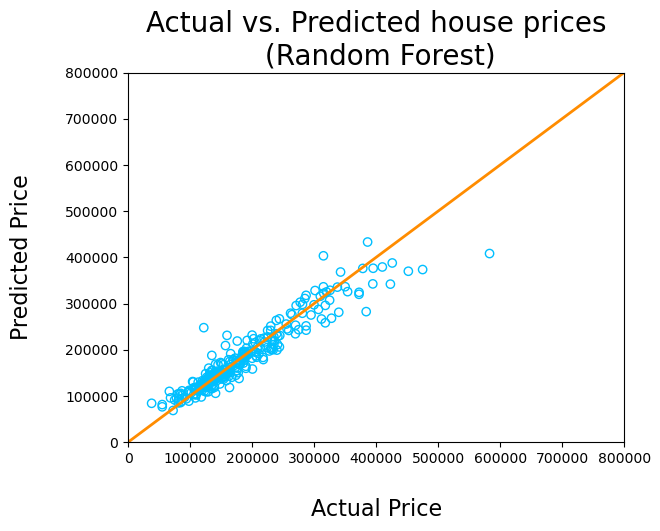

In [71]:
plt.figure()
plt.title("Actual vs. Predicted house prices\n (Random Forest)", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_ran),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

##### Reference: https://www.kaggle.com/code/emmanueldjegou/house-prices-advanced-regression-techniques